# Decision Tree using Sklearn
**Aim:** In this notebook we will take an out-of-the-box decision tree model and apply them to a given dataset, using Sklearn. The task is to analyse the data and build a model to predict whether income exceeds $50K/yr based on census data (also known as "Census Income" dataset).

The datasets are available here: http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [318]:
# Set up environment (i.e. download datasets)
!rm -f -- adult.data 
!rm -f -- adult.test
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2020-04-14 12:52:16--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test’

adult.test          100%[===================>]   1.91M  8.97MB/s    in 0.2s    

2020-04-14 12:52:16 (8.97 MB/s) - ‘adult.test’ saved [2003153/2003153]

--2020-04-14 12:52:18--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  16.0MB/s    in 0.2s    

2020-04-

## Step 1 - Importing datasets & libraries
We begin off by importing all the libraries we’ll be using and loading up the CSV data using the Pandas library. Pandas allow us to manage and manipulate data frames, which will be useful in the next step. 


In [319]:
import pandas as pd
from sklearn import tree, preprocessing, metrics
import numpy as np
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
import collections
import graphviz


# Supress dimension info from printing
pd.options.display.show_dimensions = False

labels = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income'
]
load_data = lambda input_file, head_row : pd.read_csv(
    input_file, header=head_row, names=labels, skipinitialspace=True
)
raw_trainset = load_data('adult.data', None)
raw_testset = load_data('adult.test', 0)

print('Raw Trainset:\n', raw_trainset.head())

Raw Trainset:
    age         workclass  fnlwgt  ... hours-per-week  native-country income
0   39         State-gov   77516  ...             40   United-States  <=50K
1   50  Self-emp-not-inc   83311  ...             13   United-States  <=50K
2   38           Private  215646  ...             40   United-States  <=50K
3   53           Private  234721  ...             40   United-States  <=50K
4   28           Private  338409  ...             40            Cuba  <=50K


## Step 2 - Preprocessing data
In this step, we apply to transform continuous-valued features (age, fnlwgt, education-num, capital-gain, capital-loss and hours-per-week) to discrete values, by applying a binning method. We use the pandas.cut method to group continuous values into an arbitrary number of bins, for each of our continuous-valued columns. After that, we merge a few redundant categorical values, in order to provide better generalisation.

### 1. Discretisation by Binning
We using pandas cut method to bin columns that contain continous values. This is a pretty naive approach and just allocate values into an arbitrary number of groups.

**Challenge Todo** - Looking into other binning methods, such as [optimal binning](https://www.ibm.com/support/pages/what-optimal-binning-and-how-it-done).

### 2. Data Reduction
We can merge a few categorical values, including the following:
#### Original Category Values
* **age**: continuous.
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* **fnlwgt**: continuous.
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* **education-num**: continuous.
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* **sex**: Female, Male.
* **capital-gain**: continuous.
* **capital-loss**: continuous.
* **hours-per-week**: continuous.
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

#### Updated Category Values
* **education**
    * Merge: 7th-8th, 9th, 10th, 11th, 12th -> High-school
    * Merge: 1st-4th, 5th-6th -> Primary-school



In [320]:
def preprocess(old_df):
    # Copying into new dataframe so mutations don't affect raw datasets
    df = old_df.copy()

    # Binning Continous Values
    bin_df = lambda data, num_bins : pd.cut(data, bins=num_bins, precision=0).apply(
        lambda val: f'({int(val.left)}...{int(val.right)}]'
    )
    columns_to_bin = [
        #(label, number of bins)
        ('age', 10),
        ('fnlwgt', 10),
        ('education-num', 10),
        ('capital-gain', 100),
        ('capital-loss', 100),
        ('hours-per-week', 5)
    ]
    for col in columns_to_bin:
        df[col[0]] = bin_df(df[col[0]], col[1])

    # Data Reduction - merge redundant column values 
    merge_column_values = lambda df, col, old_vals, new_val : df[col].replace(
        { val: new_val for val in old_vals },
        inplace=True
    )
    merge_column_values(
        df,
        'education',
        ['7th-8th', '9th', '10th', '11th', '12th'],
        'High-school'
    )
    merge_column_values(
        df,
        'education',
        ['1st-4th', '5th-6th'],
        'Primary-school'
    )
 
    return df

trainset = preprocess(raw_trainset)
testset = preprocess(raw_testset)

print('High-school Level (preprocessed):\n',
      trainset[trainset['education'].str.contains('High-school')])

High-school Level (preprocessed):
              age    workclass  ... native-country income
3      (46...54]      Private  ...  United-States  <=50K
6      (46...54]      Private  ...        Jamaica  <=50K
15     (32...39]      Private  ...         Mexico  <=50K
18     (32...39]      Private  ...  United-States  <=50K
22     (32...39]  Federal-gov  ...  United-States  <=50K
...          ...          ...  ...            ...    ...
32517  (32...39]      Private  ...  United-States  <=50K
32522  (54...61]      Private  ...  United-States  <=50K
32526  (32...39]      Private  ...  United-States  <=50K
32535  (17...24]      Private  ...  United-States  <=50K
32551  (32...39]      Private  ...  United-States  <=50K


## Step 3 - Encoding and Splitting the Datasets
Before we can build the model, we encode all the features and labels as integers using Sklearn’s LabelEncoder object. Each of the feature values is represented using a unique integer that can be inverted back to the original value at the end. After that, we split the training and testing datasets to their respective feature and target vectors. 


In [321]:
def split_dataset(df, target_column_label):
    le = preprocessing.LabelEncoder()
    df = df.apply(le.fit_transform)
    x_df = df.drop(target_column_label, 1)
    y_df = df[target_column_label]
    return x_df, y_df, le

x_trainset, y_trainset, le_trainset = split_dataset(trainset, 'income')
x_testset, y_testset, le_testset = split_dataset(testset, 'income')
print('Encoded Trainset Features:\n', x_trainset)
print('\nEncoded Trainset Target Values:\n', y_trainset)

Encoded Trainset Features:
        age  workclass  fnlwgt  ...  capital-loss  hours-per-week  native-country
0        3          7       1  ...             0               1              39
1        4          6       1  ...             0               0              39
2        2          4       4  ...             0               1              39
3        4          4       4  ...             0               1              39
4        1          4       5  ...             0               1               5
...    ...        ...     ...  ...           ...             ...             ...
32556    1          4       4  ...             0               1              39
32557    3          4       1  ...             0               1              39
32558    5          4       1  ...             0               1              39
32559    0          4       4  ...             0               0              39
32560    4          5       4  ...             0               1              39


## Step 4 - Building the Decision Tree
 In this step, we try several combinations of parameters (criterions & tree depths) to see which model gives us the highest accuracy. We use Sklearn’s DecisionTreeClassifier to fit the training examples into a tree and plot each parameter iteration to see how well our model does relative to the other iterations.
 
### Results: Optimal Decision Tree
After permuting several combinations of model parameters, we have found a set of parameters that give us an accuracy of 83%.

**Tree Details** ~ Criterion: gini, Tree Depth: 10, Tree Leafs: 292

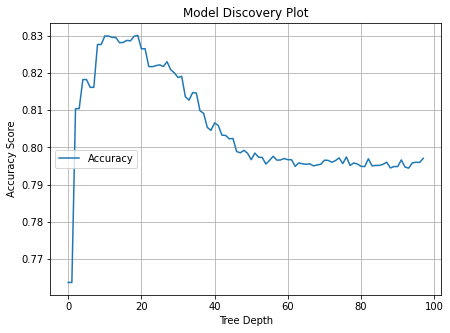

 ------------------------- 
 | Optimal Decision Tree | 
 -------------------------
	Accuracy: 0.83
	Criterion: entropy
	Tree Depth: 10
	Tree Leafs: 292


In [322]:
%matplotlib inline

# Parameters
CRITERIONS = ['gini', 'entropy']
MAX_DEPTH = 50

def find_optimal_model(features, labels):
    optimal_model = { 'accuracy': 0, 'criterion': None, 'depth': None , 'model': None }
    data = collections.defaultdict(list)
    for depth in range(1, MAX_DEPTH):
        for criterion in CRITERIONS:
            model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
            model = model.fit(features, labels)
            ŷ_testset = model.predict(x_testset)
            accuracy = metrics.accuracy_score(y_testset, ŷ_testset)
            # keep track of the parameter of the best model
            if accuracy > optimal_model['accuracy']:
                optimal_model = {
                    'accuracy': accuracy,
                    'criterion': criterion,
                    'depth': depth,
                    'model': model
                }
            # Plot model metrics
            print('Criterion:', criterion, '| Depth:', depth, '| Accuracy:', accuracy)
            data['Accuracy'].append(accuracy)
            live_plot(data)


    return optimal_model['model'], optimal_model

def live_plot(data_dict, figsize=(7,5), title='Model Discovery Plot'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='center left')
    plt.show();

model, model_stats = find_optimal_model(x_trainset, y_trainset)

print('','-'*25,'\n','| Optimal Decision Tree |','\n','-'*25)
print('\tAccuracy:', round(model_stats['accuracy'], 4))
print('\tCriterion:', model_stats['criterion'])
print('\tTree Depth:', model.get_depth())
print('\tTree Leafs:', model.get_n_leaves())

## Step 5 - Evaluating the model
In order to see how well our model performs on our testing data, we use Sklearn’s metrics class to generate a classification report containing accuracy & F1 scores.

The final accuracy we get is 83.02%, using the gini split criterion with a maximum tree depth of 10.


In [323]:
ŷ_testset = model.predict(x_testset)

print('Ground truth values:\ty =', np.array(y_testset))
print('Predicted values:\tŷ =', ŷ_testset)

classification_report = metrics.classification_report(
    y_testset,
    ŷ_testset,
    target_names=le_testset.classes_
)
print('Metrics:\n', classification_report)

Ground truth values:	y = [0 0 1 ... 0 0 1]
Predicted values:	ŷ = [0 0 0 ... 1 0 1]
Metrics:
               precision    recall  f1-score   support

      <=50K.       0.86      0.92      0.89     12435
       >50K.       0.68      0.53      0.59      3846

    accuracy                           0.83     16281
   macro avg       0.77      0.73      0.74     16281
weighted avg       0.82      0.83      0.82     16281



## Step 6 - Visualising the Decision Tree

Lastly, in order to visualise the tree, we use Graphviz to generate a decision tree diagram, using the model we generated in step 4. We render this diagram as a pdf and save it as a file.

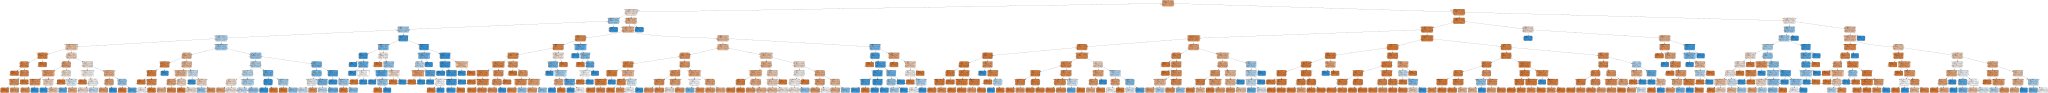

In [324]:
dot_data = tree.export_graphviz(
    model,
    feature_names=x_trainset.columns,
    class_names=le_testset.classes_,
    filled=True,
    rounded=True,
    out_file=None
)
graph = graphviz.Source(dot_data)
graph.render('tree')
display(graph)